# Convolutional neural networks - LeNet-5

A convolutional neural network with the architecture inspired by the classical LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf):

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [15]:
skip_training = False  # Set this flag to True before validation

In [6]:
data_dir = tools.select_data_dir()

The data directory is ../data


In [7]:
# Select the device for training
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [8]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## FashionMNIST dataset

The dataset is used is FashionMNIST. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw


Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw
Processing...
Done!


**Visualize the data**

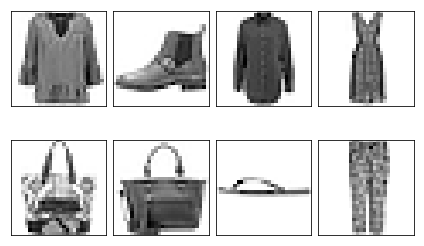

In [10]:
images, labels = iter(trainloader).next()
tests.plot_images(images[:8], n_rows=2)

## LENET convolutional network

Here I created a convolutional neural network with the architecture inspired by the classical LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf):

<img src="images/simple_net.png" width=350 style="float: left;">

The architecture of the convolutional network:
* 2d convolutional layer with:
    * one input channel
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 32 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [11]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size= 5, padding = 0)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2,padding = 0)   
        self.conv2 = nn.Conv2d(16, 32, kernel_size= 5, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(32*4*4, 120)      
        self.fc2 = nn.Linear(120, 84)        
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        y = self.pool1(F.relu(self.conv1(x)))
        y = self.pool2(F.relu(self.conv2(y)))        
        y = y.view(-1,32*4*4)     
        y = F.relu(self.fc1(y))     
        y = F.relu(self.fc2(y))      
        y = self.fc3(y)        
        return y

## Training 

In [12]:
def compute_accuracy(net, testloader):
    """
    This function computes the accuracy on the test dataset

    """
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [13]:
net = LeNet5()

In [16]:
if not skip_training:
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    n_epochs = 10
    loss_method = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            net.zero_grad()
            outputs = net(inputs)
            loss = loss_method(outputs,labels)
            loss.backward()
            optimizer.step() 

        test_accuracy = compute_accuracy(net, testloader)
        print('Train Epoch {}: Loss: {:.6f} Test accuracy {:.2f}'.format(epoch, loss.item(), test_accuracy))  

Train Epoch 0: Loss: 0.591161 Test accuracy 0.74
Train Epoch 1: Loss: 0.425151 Test accuracy 0.80
Train Epoch 2: Loss: 0.549395 Test accuracy 0.83
Train Epoch 3: Loss: 0.474556 Test accuracy 0.85
Train Epoch 4: Loss: 0.194318 Test accuracy 0.85
Train Epoch 5: Loss: 0.353112 Test accuracy 0.86
Train Epoch 6: Loss: 0.165586 Test accuracy 0.87
Train Epoch 7: Loss: 0.383853 Test accuracy 0.88
Train Epoch 8: Loss: 0.398645 Test accuracy 0.88
Train Epoch 9: Loss: 0.069043 Test accuracy 0.88


## Save model to disk

In [17]:
if not skip_training:
    tools.save_model(net, '4_lenet5.pth')
else:
    net = LeNet5()
    tools.load_model(net, '4_lenet5.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 4_lenet5.pth.


## Evaluate model performance on test set

Ground truth labels:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:          Ankle boot   Pullover    Trouser    Trouser      Shirt


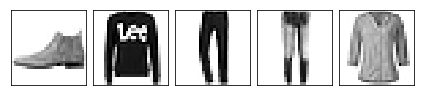

In [18]:
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    images, labels = iter(testloader).next()
    tests.plot_images(images[:5], n_rows=1)
    
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [20]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

Accuracy of the network on the test images: 0.881
